In [3]:
import pandas as pd
from prophet import Prophet
from core import get_db


c:\Users\vaish\Desktop\kachra\ThynkTechProject\venv_thynktech\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
conn = get_db()
products = pd.read_sql("SELECT product_id, name, inventory_qty FROM products WHERE is_active=1", conn)
conn.close()

C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\1843811427.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products = pd.read_sql("SELECT product_id, name, inventory_qty FROM products WHERE is_active=1", conn)


In [5]:
results = []
for _, row in products.iterrows():
    pid = row['product_id']
    pname = row['name']
    inventory = row['inventory_qty']

    # Fetch daily sales for this product
    conn = get_db()
    query = f"""SELECT DATE(created_at) as ds, SUM(qty) as y
                 FROM purchases WHERE product_id={pid}
                 GROUP BY DATE(created_at) ORDER BY ds ASC"""
    df = pd.read_sql(query, conn)
    conn.close()
    if df.empty:
        df = pd.DataFrame({'ds': pd.date_range(end=pd.Timestamp.today().normalize(), periods=30), 'y': 0})
    else:
        df['ds'] = pd.to_datetime(df['ds'])
        all_dates = pd.date_range(start=df['ds'].min(), end=pd.Timestamp.today().normalize())
        df = df.set_index('ds').reindex(all_dates, fill_value=0).rename_axis('ds').reset_index()

    # Train Prophet and forecast next 7 days
    m = Prophet(weekly_seasonality=True)
    try:
        m.fit(df)
        future = m.make_future_dataframe(periods=7)
        forecast = m.predict(future)
        # Use last 7 days for prediction
        pred_df = forecast.tail(7)
        p50_7d = pred_df['yhat'].sum()
        p90_7d = pred_df['yhat_upper'].sum() * 1.1 # Scaled upper bound for safety
    except Exception:
        # fallback: use historical mean
        base = df['y'].mean()
        p50_7d = base * 7
        p90_7d = base * 7 * 1.2
    # Optionally, recent 7-day sales
    recent7 = df['y'].tail(7).sum()
    # Suggested restock
    restock = max(0, int(round(p90_7d - inventory)))
    results.append({
        'Product': pname,
        'Inventory': int(inventory),
        'Recent7dSales': int(recent7),
        'P50_7d': round(p50_7d,2),
        'P90_7d': round(p90_7d,2),
        'SuggestedRestock': restock
    })

# To DataFrame
out_df = pd.DataFrame(results)
out_df = out_df.sort_values('SuggestedRestock', ascending=False).reset_index(drop=True)
print(out_df)


C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\4013861320.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
19:54:21 - cmdstanpy - INFO - Chain [1] start processing
19:54:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\4013861320.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
19:54:22 - cmdstanpy - INFO - Chain [1] start processing
19:54:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\4013861320.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqli

              Product  Inventory  Recent7dSales  P50_7d  P90_7d  \
0  Amigurumi Keychain         10             16   29.45   62.91   
1      Handmade Teddy         10             18   20.48   38.13   
2      Handmade Teddy          9             17   18.85   34.09   
3      Handmade Teddy         10             18   12.74   28.53   
4       Crochet Scarf         16              9   12.83   28.33   
5       Crochet Scarf         22             14   16.10   33.46   
6       Crochet Scarf         18             13   11.39   27.47   
7  Amigurumi Keychain         35             23   24.36   41.64   
8  Amigurumi Keychain         40              5    3.94   20.08   

   SuggestedRestock  
0                53  
1                28  
2                25  
3                19  
4                12  
5                11  
6                 9  
7                 7  
8                 0  


In [6]:
# script to insert rich and realistic data for each product in DB, create up to 45 days of sales records. 
'''
import random
from datetime import datetime, timedelta

# Settings
num_days = 45  # number of days of sales history to generate
max_daily_sales = 5  # max units sold per product per day

today = datetime.now()
conn = get_db()
cur = conn.cursor(dictionary=True)

# all product_ids from DB
db_products = []
cur.execute("SELECT product_id, price FROM products WHERE is_active=1")
for row in cur.fetchall():
    db_products.append((row["product_id"], float(row["price"]))
)
conn.close()

synthetic_rows = []
for product_id, price in db_products:
    for day in range(num_days):
        sale_date = today - timedelta(days=(num_days - 1 - day))
        qty = random.randint(0, max_daily_sales)  # some days 0, up to 5 sales
        if qty > 0:
            # Pick user_id 1 
            row = (1, product_id, qty, price, sale_date.strftime("%Y-%m-%d 10:%M:%S"))
            synthetic_rows.append(row)

# Bulk insert to MySQL
if synthetic_rows:
    conn = get_db()
    cur = conn.cursor()
    cur.executemany(
        """INSERT INTO purchases (user_id, product_id, qty, price_at_purchase, created_at) \
        VALUES (%s, %s, %s, %s, %s)""",
        synthetic_rows
    )
    conn.commit()
    conn.close()
    print(f"Inserted {len(synthetic_rows)} rows of synthetic sales data.")
else:
    print("No sales generated — check parameters!")
'''

'\nimport random\nfrom datetime import datetime, timedelta\n\n# Settings\nnum_days = 45  # number of days of sales history to generate\nmax_daily_sales = 5  # max units sold per product per day\n\ntoday = datetime.now()\nconn = get_db()\ncur = conn.cursor(dictionary=True)\n\n# all product_ids from DB\ndb_products = []\ncur.execute("SELECT product_id, price FROM products WHERE is_active=1")\nfor row in cur.fetchall():\n    db_products.append((row["product_id"], float(row["price"]))\n)\nconn.close()\n\nsynthetic_rows = []\nfor product_id, price in db_products:\n    for day in range(num_days):\n        sale_date = today - timedelta(days=(num_days - 1 - day))\n        qty = random.randint(0, max_daily_sales)  # some days 0, up to 5 sales\n        if qty > 0:\n            # Pick user_id 1 \n            row = (1, product_id, qty, price, sale_date.strftime("%Y-%m-%d 10:%M:%S"))\n            synthetic_rows.append(row)\n\n# Bulk insert to MySQL\nif synthetic_rows:\n    conn = get_db()\n    cur 

In [7]:
# testing model

from sklearn.metrics import mean_absolute_percentage_error

conn = get_db()
products = pd.read_sql("SELECT product_id, name, inventory_qty FROM products WHERE is_active=1", conn)
conn.close()
results = []

for _, row in products.iterrows():
    pid = row['product_id']
    pname = row['name']
    inventory = row['inventory_qty']

    # Fetch daily sales for this product
    conn = get_db()
    df = pd.read_sql(f"""
        SELECT DATE(created_at) as ds, SUM(qty) as y
        FROM purchases WHERE product_id={pid}
        GROUP BY DATE(created_at) ORDER BY ds ASC
    """, conn)
    conn.close()
    df['ds'] = pd.to_datetime(df['ds'])
    all_dates = pd.date_range(start=df['ds'].min(), end=df['ds'].max())
    df = df.set_index('ds').reindex(all_dates, fill_value=0).rename_axis('ds').reset_index()
    if len(df) < 14:
        continue  # Needs enough history for test + training

    # Split/train/test
    train_df = df.iloc[:-7]
    test_df = df.iloc[-7:]
    m = Prophet(weekly_seasonality=True)
    m.fit(train_df)
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    test_pred = forecast[['ds','yhat']].tail(7)

    # Accuracy
    actual = test_df['y'].values
    pred = test_pred['yhat'].values
    mape = mean_absolute_percentage_error(actual, pred) * 100

    # Full forecast for restock suggestion
    full_pred = forecast[['ds','yhat','yhat_upper']].tail(7)
    p50_7d = full_pred['yhat'].sum()
    p90_7d = full_pred['yhat_upper'].sum() * 1.1
    recent7 = df['y'].tail(7).sum()
    restock = max(0, int(round(p90_7d - inventory)))

    results.append({
        'Product': pname,
        'Inventory': int(inventory),
        'Recent7dSales': int(recent7),
        'P50_7d': round(p50_7d,2),
        'P90_7d': round(p90_7d,2),
        'SuggestedRestock': restock,
        'MAPE_last7': round(mape,2)
    })

out_df = pd.DataFrame(results)
out_df = out_df.sort_values('MAPE_last7').reset_index(drop=True)
print(out_df)


C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\2599751998.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products = pd.read_sql("SELECT product_id, name, inventory_qty FROM products WHERE is_active=1", conn)
C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\2599751998.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"""
19:54:28 - cmdstanpy - INFO - Chain [1] start processing
19:54:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\2599751998.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are n

              Product  Inventory  Recent7dSales  P50_7d  P90_7d  \
0  Amigurumi Keychain         35             27   21.37   38.65   
1      Handmade Teddy          9             18   22.00   37.95   
2       Crochet Scarf         18             16   11.43   27.64   
3      Handmade Teddy         10             19   22.22   39.84   
4      Handmade Teddy         10             18   11.76   26.80   
5       Crochet Scarf         16             11   20.39   35.96   
6       Crochet Scarf         22             15   24.19   40.89   
7  Amigurumi Keychain         40              5   12.02   29.70   
8  Amigurumi Keychain         10             20   38.26   72.59   

   SuggestedRestock    MAPE_last7  
0                 4  3.750000e+01  
1                29  8.602000e+01  
2                10  1.200520e+17  
3                30  1.409860e+17  
4                17  2.068795e+17  
5                20  2.419982e+17  
6                19  3.618069e+17  
7                 0  4.910067e+17  
8    

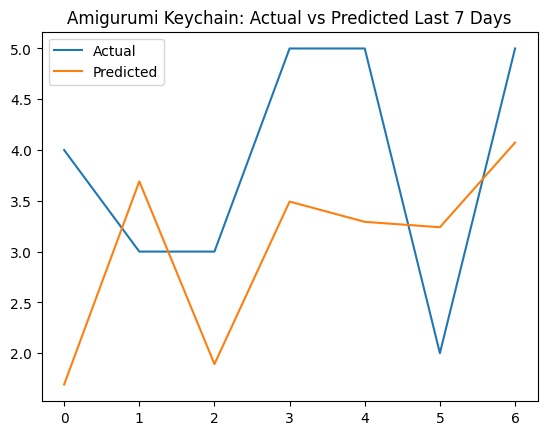

In [8]:
# visual testing

import matplotlib.pyplot as plt
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.title(f'{pname}: Actual vs Predicted Last 7 Days')
plt.show()


In [9]:
from core import get_db
import pandas as pd

tables = ['products', 'purchases', 'tags', 'product_tags']
for table in tables:
    conn = get_db()
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    conn.close()
    df.to_csv(f"{table}.csv", index=False)
out_df.to_csv("forecast_results.csv", index=False)


C:\Users\vaish\AppData\Local\Temp\ipykernel_9928\2552078581.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {table}", conn)
